In [44]:
import os
import cv2
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imgaug.augmenters as iaa
from tensorflow.keras.models import load_model
from itertools import chain
from pathlib import Path
from skimage.io import imread
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Graphing
import seaborn as sns

# Check for GPU and allocate a fixed amount of GPU mem
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
  except RuntimeError as e:
    print(e)

In [45]:
# Base file path for data
data_path = Path('C://Users//Gabriel//Desktop//CS3244//PneumoniaCNN//chest_xray')

# File path for training images
train_path = data_path / 'train'

# File path for testing images
test_path = data_path / 'test'

In [46]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               brightness_range=[0.8,1.2], # Vary brightness between range +-
                               fill_mode='nearest')

image_shape = (112, 112, 1)

# early_stop = EarlyStopping(monitor='val_loss',patience=2)

batch_size = 16

In [47]:
sample_image = test_path / 'PNEUMONIA' / 'person76_virus_138.jpeg'

imread(sample_image).shape

(744, 1224)

In [48]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary')

test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [49]:
train_image_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [50]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, SeparableConv2D, AveragePooling2D, DepthwiseConv2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [65]:
model_input = Input(shape=image_shape)

conv_layer_1 = Conv2D(16, (3,3), activation='relu', padding='same')(model_input)
conv_layer_1 = Conv2D(32, (3,3), activation='relu')(conv_layer_1)
conv_layer_1 = BatchNormalization()(conv_layer_1)
pooling_layer_1 = MaxPooling2D((2,2))(conv_layer_1)

# conv_layer_2 = SeperableConv2D(128, (3,3), activation='relu', padding='same')(pooling_layer_1)
# conv_layer_2 = BatchNormalization()(conv_layer_2)
# pooling_layer_2 = MaxPooling2D((2,2))(conv_layer_2)

conv_layer_2 = Conv2D(64, (3,3), activation='relu')(pooling_layer_1)
conv_layer_2 = Conv2D(96, (3,3), activation='relu')(conv_layer_2)
conv_layer_2 = BatchNormalization()(conv_layer_2)
pooling_layer_2 = MaxPooling2D((2,2))(conv_layer_2)

# # Inception v2
# conv_layer_2 = Conv2D(32, (3,3), activation='relu', padding='same')(pooling_layer_1)
# conv_layer_2 = BatchNormalization()(conv_layer_2)
# pooling_layer_2 = MaxPooling2D((2,2))(conv_layer_2)
# pooling_layer_2 = Conv2D(128, (1,1), activation='relu')(pooling_layer_2)

x1 = Conv2D(32, (1,1), activation='relu')(pooling_layer_2)

x2 = Conv2D(32, (1,1), activation='relu')(pooling_layer_2)
x2 = Conv2D(64, (3,3), activation='relu', padding='same')(x2)

x3 = Conv2D(32, (1,1), activation='relu')(pooling_layer_2)
x3 = Conv2D(64, (5,5), activation='relu', padding='same')(x3)

x4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(pooling_layer_2)
x4 = Conv2D(32, (1,1), activation='relu')(x4)

inception_layer = concatenate([x1, x2, x3, x4])

# # Inception v2

model = DepthwiseConv2D((3,3), activation='relu')(inception_layer)

model = SeparableConv2D(96, (3,3), activation='relu')(model)

model = BatchNormalization()(model)

# model = MaxPooling2D((2,2))(model)

# model = Conv2D(64, (1,1), activation='relu')(inception_layer)

model = Flatten()(model)

model = Dense(128, activation='relu')(model)

model = Dropout(0.5)(model)

model_output = Dense(1, activation='sigmoid')(model)

model = Model(inputs=model_input, outputs=model_output)

model.compile(loss='binary_crossentropy',
              optimizer='RMSProp',
              metrics=['accuracy'])


In [66]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 112, 112, 1) 0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 112, 112, 16) 160         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 110, 110, 32) 4640        conv2d_54[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 110, 110, 32) 128         conv2d_55[0][0]                  
____________________________________________________________________________________________

In [67]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
from tensorflow.keras import backend as K

class printLR(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(K.eval(self.model.optimizer.lr))

In [54]:
results = model.fit(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                               callbacks=[ReduceLROnPlateau(), printLR()])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 326 steps, validate for 39 steps
Epoch 1/20
326/326 [==============================] - 140s 428ms/step - loss: 0.2294 - accuracy: 0.9070 - val_loss: 0.4705 - val_accuracy: 0.7628
Epoch 2/20
326/326 [==============================] - 139s 425ms/step - loss: 0.1995 - accuracy: 0.9201 - val_loss: 2.6070 - val_accuracy: 0.6250
Epoch 3/20
326/326 [==============================] - 138s 423ms/step - loss: 0.1960 - accuracy: 0.9245 - val_loss: 0.5122 - val_accuracy: 0.8189
Epoch 4/20
326/326 [==============================] - 134s 412ms/step - loss: 0.1766 - accuracy: 0.9363 - val_loss: 0.6614 - val_accuracy: 0.6394
Epoch 5/20
326/326 [==============================] - 136s 418ms/step - loss: 0.1539 - accuracy: 0.9406 - val_loss: 1.6034 - val_accuracy: 0.7099
Epoch 6/20
326/326 [==============================] - 137s 419ms/step - loss: 0.1577 - accuracy: 0.9421 - val_loss: 0.8056 - val_accuracy: 0.7131
Epoch 7/20
326/326 [===========

In [55]:
from tensorflow.keras.models import load_model
model.save('curr_model.h5')

In [56]:
losses = pd.DataFrame(model.history.history)

In [57]:
metric_names = model.metrics_names
metric_values = model.evaluate_generator(test_image_gen)


for i in range(len(model.metrics_names)):
    print("{name:s}: {value:.5f}".format(name=metric_names[i], value=metric_values[i]))

  ...
    to  
  ['...']
loss: 0.71303
accuracy: 0.81891


In [58]:
from tensorflow.keras.preprocessing import image
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [59]:
pred_probabilities

array([[6.89064488e-02],
       [6.82280362e-01],
       [6.59657478e-01],
       [7.20487952e-01],
       [1.20119259e-01],
       [2.73615755e-02],
       [6.39376044e-02],
       [7.68418014e-01],
       [9.57767785e-01],
       [9.84187350e-02],
       [2.29619235e-01],
       [9.73591089e-01],
       [5.47883928e-01],
       [3.84832323e-02],
       [9.34499145e-01],
       [1.90033942e-01],
       [9.76405144e-01],
       [1.73178986e-01],
       [4.70464677e-03],
       [7.72106871e-02],
       [5.16864717e-01],
       [2.32905038e-02],
       [9.56403255e-01],
       [3.02265901e-02],
       [8.28828812e-01],
       [8.38910222e-01],
       [9.13487017e-01],
       [4.91541088e-01],
       [2.15854093e-01],
       [5.93916297e-01],
       [9.39390123e-01],
       [7.85843670e-01],
       [6.51218295e-01],
       [1.40380532e-01],
       [9.17536914e-01],
       [6.44555688e-02],
       [3.32467716e-05],
       [5.04085375e-03],
       [7.33133480e-02],
       [4.25843224e-02],


In [60]:
predictions = pred_probabilities > 0.5

In [61]:
# Only for binary classification
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.47      0.63       234
           1       0.76      0.99      0.86       390

    accuracy                           0.79       624
   macro avg       0.86      0.73      0.74       624
weighted avg       0.83      0.79      0.77       624



<Figure size 432x288 with 0 Axes>

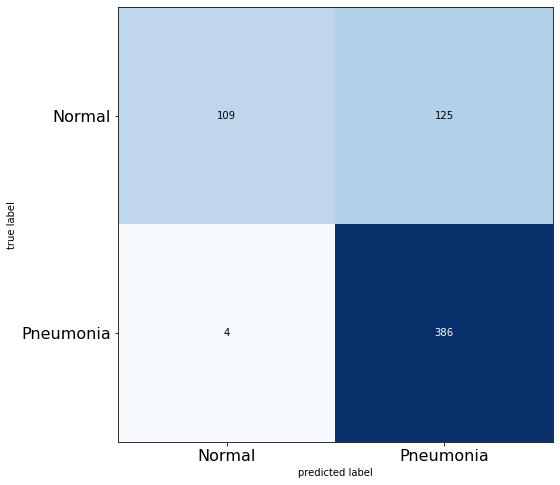

In [62]:
cm  = confusion_matrix(test_image_gen.classes, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()